# **Official Solution to HW1: COVID-19 Cases Prediction (Regression)**

Author: Heng-Jui Chang

Methods:
* Training with all data
* Feature selection (14 important features)
* DNN architecture (dimension=91, activation=RReLU)
* Training (mini-batch=135, optimizer=SGD, learning rate=0.001)
* L2 regularization
* Sharing the same normalization mean and std between the training and testing sets.

Running this code on Google Colab probably passes all baselines on Kaggle (public = 0.87530 / private = 0.89223).  
The training hyper-parameters are tuned manually, do not ask why this combination works because we do not know either.


## **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [1]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 64.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 10.3MB/s]


# **Import Some Packages**

In [2]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# **Some Utilities**

You do not need to modify this part.

In [3]:
def random_seed_setup(seed):
    # For reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        return 'cuda'
    else:
        return 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

In [4]:
class Covid19Dataset(Dataset):
    def __init__(self,
                 path,
                 mode='train',
                 normalize='none',
                 target_only=False,
                 norm_mean=None,
                 norm_std=None):
        self.mode = mode

        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            self.data_class = data[0][1:]
            data = np.array(data[1:])[:, 1:].astype(float)
        
        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if not target_only:
            feats = list(range(93))
        else:
            feats = 40 + np.array([0, 1, 2, 3, 17, 18, 19, 20, 21, 35, 36, 37, 38, 39])

        if mode == 'test':
            # Testing data
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = list(range(893))
            else:
                indices = list(range(len(data)))
                # only when mode == 'train_all' (i.e., using all data for training)
            
            data = data[indices]
            target = target[indices]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data)
            self.target = torch.FloatTensor(target)
        
        self.norm_mean = None
        self.norm_std = None

        if normalize == 'self':
            self.norm_mean = self.data.mean(dim=0).unsqueeze(0)
            self.norm_std = self.data.std(dim=0).unsqueeze(0)
            self.data = (self.data - self.norm_mean) / self.norm_std

        if normalize == 'given' and (norm_mean is not None) and (norm_std is not None):
            self.data = (self.data - norm_mean) / norm_std

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of the Covid19 Dataset ({} samples found, each dim = {})'
              .format(mode, self.data.shape[0], self.data.shape[1]))

    def __getitem__(self, index):
        if self.mode in ['train', 'dev', 'train_all']:
            return self.data[index], self.target[index]
        else:
            return self.data[index]

    def __len__(self):
        return len(self.data)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [5]:
def prep_dataloader(tr_path, tt_path, batch_size, n_jobs=0, target_only=False):
    tr_dataset = Covid19Dataset(
        tr_path, mode='train_all',
        normalize='self', 
        target_only=target_only)

    dv_dataset = Covid19Dataset(
        tr_path, mode='dev',
        normalize='given', 
        target_only=target_only,
        norm_mean=tr_dataset.norm_mean,
        norm_std=tr_dataset.norm_std)

    tt_dataset = Covid19Dataset(
        tt_path, mode='test',
        normalize='given',
        target_only=target_only,
        norm_mean=tr_dataset.norm_mean,
        norm_std=tr_dataset.norm_std)
    
    tr_dataloader = DataLoader(
        tr_dataset, batch_size,
        shuffle=True, drop_last=False,
        num_workers=n_jobs, pin_memory=True)
    
    dv_dataloader = DataLoader(
        dv_dataset, batch_size,
        shuffle=False, drop_last=False,
        num_workers=n_jobs, pin_memory=True)

    tt_dataloader = DataLoader(
        tt_dataset, batch_size,
        shuffle=False, drop_last=False,
        num_workers=n_jobs, pin_memory=True)
    
    return tr_dataloader, dv_dataloader, tt_dataloader

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [6]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim, l2_reg=0.):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        self.net = nn.Sequential(
            nn.Linear(input_dim, 91),
            nn.RReLU(),  # randomized ReLU
            nn.Linear(91, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')
        self.l2_reg = l2_reg

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target, is_train=True):
        ''' Calculate loss '''
        total_loss = 0

        mse_loss = self.criterion(pred, target)
        total_loss += mse_loss
        if is_train and self.l2_reg > 0.:
            reg_loss = 0
            for param in self.parameters():
                reg_loss += torch.norm(param, p=2)
            total_loss += reg_loss * self.l2_reg
        
        return total_loss, mse_loss

# **Train/Dev/Test**

## **Training**

In [7]:
def train(tr_set, dv_set, model, config, device):
    n_epochs = config['n_epochs']
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    loss_record = {'train': []}
    epoch = 0
    while epoch < n_epochs:
        model.train()
        for i, (x, y) in enumerate(tr_set):
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total_loss, mse_loss = model.cal_loss(pred, y, is_train=True)
            total_loss.backward()
            optimizer.step()
            loss_record['train'].append(total_loss.detach().cpu().item())

        dev_mse = dev(dv_set, model, device)
        
        print('Saving model (epoch = {:3d})'
              .format(epoch + 1))
        torch.save(model.state_dict(), config['save_path'])

        epoch += 1

    print('Finished training after {} epochs'.format(epoch))

    return loss_record

def dev(dv_set, model, device):
    model.eval()
    total_loss = 0
    for x, y in dv_set:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            _, mse_loss = model.cal_loss(pred, y, is_train=False)
        total_loss += mse_loss.detach().cpu().item() * len(x)
    total_loss = total_loss / len(dv_set.dataset)

    return total_loss

## **Testing**

In [8]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [9]:
device = random_seed_setup(42097)
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True

config = {
    'n_epochs': 80,                  # maximum number of epochs
    'batch_size': 135,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 20,                # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

# **Load data and model**

In [10]:
tr_set, dv_set, tt_set = prep_dataloader(
    tr_path, tt_path, config['batch_size'], 
    target_only=target_only)

Finished reading the train_all set of the Covid19 Dataset (2700 samples found, each dim = 14)
Finished reading the dev set of the Covid19 Dataset (893 samples found, each dim = 14)
Finished reading the test set of the Covid19 Dataset (893 samples found, each dim = 14)


In [11]:
model = NeuralNet(tr_set.dataset.dim, 0.001).to(device)  # Construct model and move to device

# **Start Training!**

In [12]:
model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =   1)
Saving model (epoch =   2)
Saving model (epoch =   3)
Saving model (epoch =   4)
Saving model (epoch =   5)
Saving model (epoch =   6)
Saving model (epoch =   7)
Saving model (epoch =   8)
Saving model (epoch =   9)
Saving model (epoch =  10)
Saving model (epoch =  11)
Saving model (epoch =  12)
Saving model (epoch =  13)
Saving model (epoch =  14)
Saving model (epoch =  15)
Saving model (epoch =  16)
Saving model (epoch =  17)
Saving model (epoch =  18)
Saving model (epoch =  19)
Saving model (epoch =  20)
Saving model (epoch =  21)
Saving model (epoch =  22)
Saving model (epoch =  23)
Saving model (epoch =  24)
Saving model (epoch =  25)
Saving model (epoch =  26)
Saving model (epoch =  27)
Saving model (epoch =  28)
Saving model (epoch =  29)
Saving model (epoch =  30)
Saving model (epoch =  31)
Saving model (epoch =  32)
Saving model (epoch =  33)
Saving model (epoch =  34)
Saving model (epoch =  35)
Saving model (epoch =  36)
Saving model (epoch =  37)
S

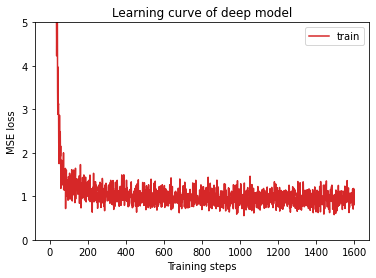

In [13]:
plot_learning_curve(model_loss_record, title='deep model')

In [14]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)

<All keys matched successfully>

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [15]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author.